# Exploring Neighborhoods in Karachi, Pakistan

## Table of Content
1. [Introduction](#intro)
2. [Data Collection](#dc)
3. [Methodology](#meth)
4. [Analysis](#ana)
5. [Results and Discussion](#rd)
6. [Conclusion](#conc)

## Introduction <a name="intro"></a>

This project aims to identify popular neighborhoods and explore its venues in Karachi, Pakistan which is based on their overall rating, its reviews and also its price ranges using Foursquare API and cluster the neighborhoods and venues to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the API and Data Science. Once we have the plot neighborhoods with their venues, any company can launch an application using the same data and suggest users such information.

## Data Collection <a name="dc"></a>

According to our problem we need the following data:
* Borough
* Neighborhood
* Venues

Following data sources will be needed to extract/generate the required information:

Source : https://en.wikipedia.org/wiki/List_of_Union_Councils_of_Karachi

We will also fetch the data from APIs.
**Foursquare API:** We will use the Foursquare API to fetch venues in Karachi in the radius of 2 Kilometers on each neighborhood.

### Import Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder
from geopy.geocoders import Nominatim
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm

First we will extract borough from the source because both borough and neighborhoods data are on different pages of the website. Then we will loop on the borough data and extract its neighborhood through scraping

In [2]:
#for extracting borough
source = requests.get('https://en.wikipedia.org/wiki/List_of_Union_Councils_of_Karachi').text
soup = BeautifulSoup(source,'lxml')
uc_tab = soup.find('div', class_='toc').ul
district = []
for lis in uc_tab.find_all('li',class_='toclevel-2'):
    district.append(lis.find('span', class_='toctext').text)
    
district[0:5] #display some

['Baldia Town', 'Bin Qasim Town', 'Gadap Town', 'Gulberg Town', 'Gulshan Town']

In [3]:
#now extracting neighborhood
town = []
districts = [] 
dist_and_town = {}
for dis_links in district:
    source2 = requests.get('https://en.wikipedia.org/wiki/{}'.format(dis_links)).text
    soup2 = BeautifulSoup(source2,'lxml')
    try:
        neigh_tab = soup2.find('div',class_='div-col columns column-width')
        for lis2 in neigh_tab.find_all('li'):
            town.append(lis2.text)
            districts.append(dis_links)
    except Exception as e:
        pass

dist_and_town = {'Borough':districts,'Neighborhood':town}

We will create dataframe from the scrape data

In [4]:
df_khi = pd.DataFrame(dist_and_town)
df_khi.head()

,Borough,Neighborhood
0,Bin Qasim Town,Abdullah Goth
1,Bin Qasim Town,Cattle Colony
2,Bin Qasim Town,Gaghar
3,Bin Qasim Town,Green Park City
4,Bin Qasim Town,Gulshan-e-Hadeed


In [5]:
df_khi.shape

(220, 2)

**Some data also added manually**

In [6]:
#read file
df_khi = pd.read_csv('karachi_district.csv')
df_khi.head()

,Borough,Neighborhood
0,Bin Qasim Town,Abdullah Goth
1,Bin Qasim Town,Cattle Colony
2,Bin Qasim Town,Gaghar
3,Bin Qasim Town,Green Park City
4,Bin Qasim Town,Gulshan-e-Hadeed


In [7]:
df_khi.shape

(294, 2)

**Find the Co-ordiantes of each Neighborhood**

In [8]:
latitude = []
longitude = []
for t_loc in df_khi['Neighborhood']: 
    address = '{},Karachi,Pakistan'.format(t_loc)
    geolocator = Nominatim(user_agent='khi_explorer')
    location = geolocator.geocode(address,timeout=1000)
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except Exception as e:
        latitude.append("")
        longitude.append("")

In [9]:
df_khi['Latitude'] = latitude
df_khi['Longitude'] = longitude
df_khi.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bin Qasim Town,Abdullah Goth,24.8665,67.2837
1,Bin Qasim Town,Cattle Colony,24.8793,67.1987
2,Bin Qasim Town,Gaghar,,
3,Bin Qasim Town,Green Park City,24.8577,67.2225
4,Bin Qasim Town,Gulshan-e-Hadeed,24.87,67.3601


We have to drop the data which dont have the Longitude and Latitude

In [10]:
#first check
len(df_khi[df_khi['Latitude'] == ''])

81

In [11]:
#drop
df_khi.drop(df_khi[df_khi['Latitude'] == ""].index,axis=0,inplace=True)

In [12]:
#check again
len(df_khi[df_khi['Latitude'] == ''])

0

In [13]:
df_khi.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bin Qasim Town,Abdullah Goth,24.8665,67.2837
1,Bin Qasim Town,Cattle Colony,24.8793,67.1987
3,Bin Qasim Town,Green Park City,24.8577,67.2225
4,Bin Qasim Town,Gulshan-e-Hadeed,24.87,67.3601
5,Bin Qasim Town,Ibrahim Hyderi,24.7916,67.1409


In [14]:
df_khi.shape

(213, 4)

We can use the geopy library to extract the latitude and longitude values of karachi but it seems off and thus, we'll directly supply the values in this case.

Let's use the folium library to create a complete map of Karachi and its neighborhoods superimpose on them

In [15]:
map_khi = folium.Map(
    location=[24.9008, 67.1681], 
    zoom_start=10
)

### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'YNHW0YK3AVH1W52ZVN5JBUXILERKT20M1FHTSURIKUBX44Q0' # your Foursquare ID
CLIENT_SECRET = 'I3VT2XGXAG34A4RQXAJCRBUI2ELJVQJLQXG5VST2OLIBZRJR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: YNHW0YK3AVH1W52ZVN5JBUXILERKT20M1FHTSURIKUBX44Q0
CLIENT_SECRET:I3VT2XGXAG34A4RQXAJCRBUI2ELJVQJLQXG5VST2OLIBZRJR


###  Explore Each Neighborhood's Venues in Karachi

Create a function to extract the venues from each Neighborhood

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID','Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
khi_venues = getNearbyVenues(names=df_khi['Neighborhood'],
                                   latitudes=df_khi['Latitude'],
                                   longitudes=df_khi['Longitude']
                                  )


In [19]:
#I save it not to run again and again
khi_venues = pd.read_csv('karachi_venues.csv')

In [20]:
print(khi_venues.shape)
khi_venues.head()

(3113, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cattle Colony,24.879311,67.198723,4ca21645e44d6dcb4dde0375,Anwar Baloch,24.869620,67.200499,BBQ Joint
1,Cattle Colony,24.879311,67.198723,4dbadad51e72b351ca89bc12,The Broast Restaurant,24.884536,67.182993,Fast Food Restaurant
2,Cattle Colony,24.879311,67.198723,4fe5a492e4b02e4293b64533,Student Biryani,24.884636,67.182260,Restaurant
3,Cattle Colony,24.879311,67.198723,4ec2103893ad36d7aa12a7c5,Taj Chaiye Ka Hotel,24.887062,67.183052,Tea Room
4,Cattle Colony,24.879311,67.198723,4ec785a0722e1437965e2e90,Liaquat Market,24.887072,67.183061,Market


Now we want to explore each venues from the dataframe like its ratings, price ranges and tips.

In [21]:
def append_str(re):
    try:
        rating = re['rating']
    except:
        rating = 0
    try:
        tips = re['tips']['count']
    except:
        tips = 0
    try:
        price = re['price']['message']
    except:
        price = "Not listed"

    return rating,tips,price

In [ ]:
venues_data = []
for v_id in khi_venues['Venue ID'].head(500):  #we'll explore only 500 venues because of API calls limitation
    venue_id = '4b89778df964a520073932e3'
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION
    )
    
    results = requests.get(url).json()
    #print(results['response']['venue']['rating'],results['response']['venue']['tips']['count'])
    venues_data.append(append_str(results['response']['venue']))

venues_data

In [ ]:
total_venues = pd.DataFrame(venues_data, columns=['Ratings','Tips','Price'])

In [22]:
#T saved it to not utilize my calls again
total_venues = pd.read_csv("total_venues.csv")
total_venues.head()

,Ratings,Tips,Price
0,7.1,13,Moderate
1,0.0,1,Cheap
2,0.0,0,Moderate
3,0.0,1,Moderate
4,0.0,3,Not listed


In [23]:
total_venues.shape

(501, 3)

**Filter venues**

In [24]:
selected_venues = total_venues[(total_venues['Ratings'] != 0) & (total_venues['Price'] != "Not listed") & (total_venues['Tips'] != 0.0)]
selected_venues

,Ratings,Tips,Price
0,7.1,13,Moderate
17,8.6,5,Cheap
18,7.5,2,Cheap
19,7.3,8,Cheap
20,7.6,3,Cheap
...,...,...,...
490,6.0,2,Cheap
491,6.0,17,Cheap
494,5.7,3,Cheap
496,6.0,17,Cheap


**Sort venues by ratings**

In [26]:
selected_venues = selected_venues.sort_values(by="Ratings",ascending=False)
selected_venues.head()

,Ratings,Tips,Price
420,8.7,17,Cheap
17,8.6,5,Cheap
178,8.6,5,Cheap
125,8.6,5,Cheap
92,8.6,5,Cheap


In [27]:
selected_venues.reset_index(drop=True,inplace=True)
selected_venues

,Ratings,Tips,Price
0,8.7,17,Cheap
1,8.6,5,Cheap
2,8.6,5,Cheap
3,8.6,5,Cheap
4,8.6,5,Cheap
...,...,...,...
242,5.7,3,Cheap
243,5.7,6,Moderate
244,5.6,1,Cheap
245,5.6,7,Moderate


**Now merged the Venues and Neighborhood Dataframe**

In [28]:
khi_merged = khi_venues.join(selected_venues)
khi_merged.drop('Venue ID',axis=1,inplace=True)
khi_merged = khi_merged[0:247]
khi_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Ratings,Tips,Price
0,Cattle Colony,24.879311,67.198723,Anwar Baloch,24.869620,67.200499,BBQ Joint,8.7,17.0,Cheap
1,Cattle Colony,24.879311,67.198723,The Broast Restaurant,24.884536,67.182993,Fast Food Restaurant,8.6,5.0,Cheap
2,Cattle Colony,24.879311,67.198723,Student Biryani,24.884636,67.182260,Restaurant,8.6,5.0,Cheap
3,Cattle Colony,24.879311,67.198723,Taj Chaiye Ka Hotel,24.887062,67.183052,Tea Room,8.6,5.0,Cheap
4,Cattle Colony,24.879311,67.198723,Liaquat Market,24.887072,67.183061,Market,8.6,5.0,Cheap


## Methodology <a name="meth"></a>

The methodology in this project consists of two parts:

As a first step, we retrieved the data from Foursquare APIs. We extract venue information from the each neighborhood, upto a distance of 2 Km. The latitude and longitude values fetch through web scraping.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. 

We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="ana"></a>

The complete dataset is now in its final form.

We will now analyze venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 10. We'll also analyse the venues based on their range.

We have different types of venues in each neighborhood. We will take a look at the venues and check which are the majority venue neighborhood in the list.

### Most Venues

In [29]:
khi_venues.groupby('Neighborhood')['Venue'].count().sort_values(ascending=False).to_frame().head()

,Venue
Neighborhood,
Clifton,100
Mahmudabad,100
Bath Island,100
Shah Rasool Colony,100
Civil Lines,91


From the above result we can clearly see that **Clifton, Mahmudabad and Bath Island** has most values in the list. So, if you are a tourist, you may find many places to enjoy there

### Categories

Now we will take a look at the venues and check how many unique venue categories are and which are the majority venue categories in the list.

In [30]:
print('There are {} uniques venue categories visitor can find in Karachi'.format(len(khi_venues['Venue Category'].unique())))

There are 150 uniques venue categories visitor can find in Karachi


We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

In [31]:
khi_venues['Venue Category'].value_counts().to_frame().head(5)

,Venue Category
Fast Food Restaurant,289
Market,148
Pizza Place,136
BBQ Joint,132
Bakery,130


**Visulaize**

Text(0.5, 1.0, 'Count each venue category')

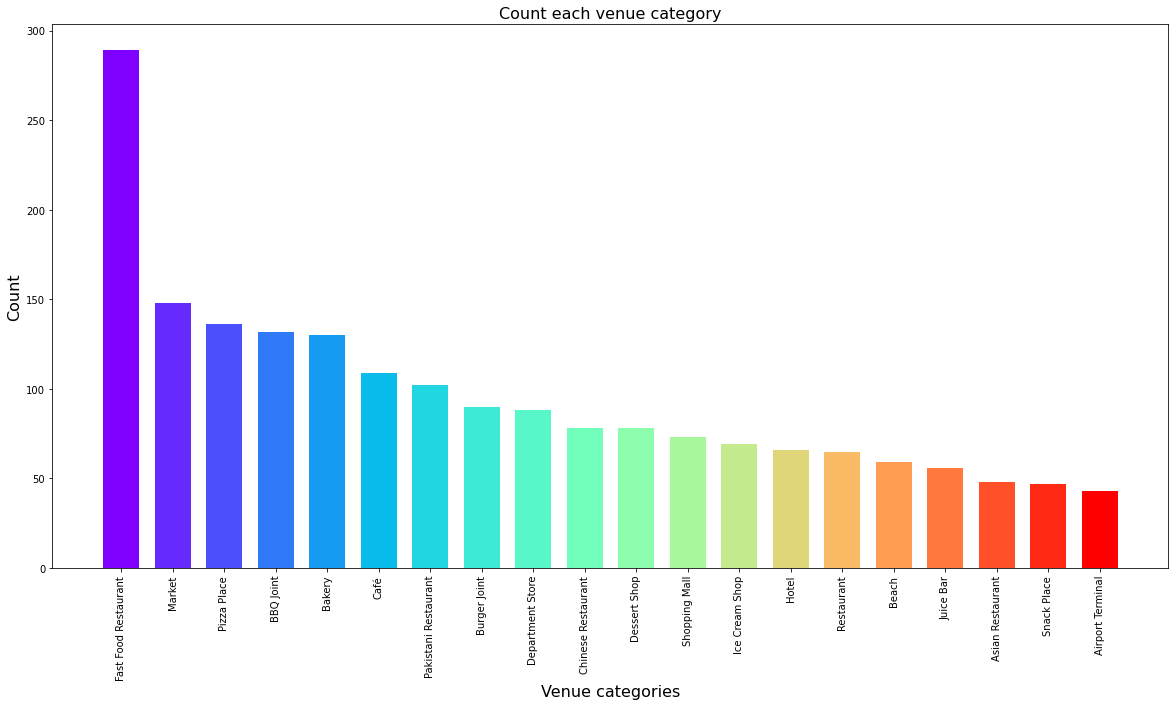

In [32]:
cat_dis = khi_venues['Venue Category'].value_counts().head(20) 
plt.figure(figsize = (20,10))
colors = cm.rainbow(np.linspace(0, 1, len(cat_dis.index)))
plt.xticks(rotation = 90)
plt.bar(cat_dis.index,cat_dis.values,color = colors,width=0.7)
plt.xlabel("Venue categories", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count each venue category", fontsize = 16)

We can conclude that Fast Food Restaurant category venues are here the most

### Ratings

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place.
We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

In [33]:
khi_merged[['Venue','Venue Latitude','Venue Longitude','Venue Category','Ratings','Tips','Price']].head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Ratings,Tips,Price
0,Anwar Baloch,24.869620,67.200499,BBQ Joint,8.7,17.0,Cheap
1,The Broast Restaurant,24.884536,67.182993,Fast Food Restaurant,8.6,5.0,Cheap
2,Student Biryani,24.884636,67.182260,Restaurant,8.6,5.0,Cheap
3,Taj Chaiye Ka Hotel,24.887062,67.183052,Tea Room,8.6,5.0,Cheap
4,Liaquat Market,24.887072,67.183061,Market,8.6,5.0,Cheap


We can see that Anwar Baloch has highest rating so this might be the place you have to visit

We can also analyze which neighborhood has highest rating restaurant

In [34]:
khi_merged.groupby('Neighborhood')['Ratings'].mean().sort_values(ascending=False).to_frame()[0:5]

,Ratings
Neighborhood,
Cattle Colony,8.477778
Green Park City,8.200000
Gulshan-e-Hadeed,8.200000
Landhi Colony,7.900000
Ibrahim Hyderi,7.900000


Here we can see that Cattle Colony has the highest rating restaurant 

### Price

In [35]:
khi_merged["Price"].unique()

array(['Cheap', 'Moderate', 'Very Expensive'], dtype=object)

We will now take a look the venues based on the price ranges. We have three price features for our venues, Cheap, Moderate and Very Expensive according to Foursquare API

Now we map the cheap restaurant in map

Users might also be interested in going to a place that fits in their budget. We will use the **Price** column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [36]:
khi_merged_dum = khi_merged[0:40] #visualize only top40 venues from the list
color_map = {'Cheap': 'green', 'Moderate': 'orange', 'Very Expensive': 'red'}
for name, lat, lng, price in zip(khi_merged_dum["Venue"],khi_merged_dum["Venue Latitude"],khi_merged_dum["Venue Longitude"],khi_merged_dum["Price"]):
    label = '{}'.format(name)
    label = folium.Popup(label,parse_html=True)
    folium.Marker(
        [lat,lng],
        icon = folium.Icon(color = color_map[price]),
        popup = label
    ).add_to(map_khi)

map_khi

We can verify our analysis through take a look at our dataset

In [37]:
khi_merged[khi_merged["Price"] == "Cheap"].groupby('Neighborhood')["Price"].value_counts().sort_values(ascending=False).to_frame().head(5)

,,Price
Neighborhood,Price,
Mujahid Colony,Cheap,29
Gulshan-e-Iqbal I,Cheap,29
Shanti Nagar,Cheap,27
Gulshan-e-Iqbal II,Cheap,18
Gulistan-e-Johar,Cheap,17


We can see that most of the cheap restaurants are found in Gulshan-e-Iqbal and Mujahid Colony

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [43]:
from sklearn.cluster import KMeans
kcluster = 2

khi_cluster = khi_merged[['Price',"Ratings","Tips"]]

In [44]:
khi_cluster.head()

,Price,Ratings,Tips
0,Cheap,8.7,17.0
1,Cheap,8.6,5.0
2,Cheap,8.6,5.0
3,Cheap,8.6,5.0
4,Cheap,8.6,5.0


To fit the model we have to convert categorical variable into numerical variable

In [45]:
khi_cluster['Price'] = khi_cluster['Price'].replace(to_replace=["Cheap","Moderate","Very Expensive"], value=[0,1,2])

c:\users\aitezaz akhtar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
khi_cluster.head()

,Price,Ratings,Tips
0,0,8.7,17.0
1,0,8.6,5.0
2,0,8.6,5.0
3,0,8.6,5.0
4,0,8.6,5.0


In [47]:
kmeans = KMeans(n_clusters=kcluster, random_state=0).fit(khi_cluster)

In [48]:
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Add clustering labels**

In [49]:
khi_merged.insert(0,"Cluster Labels",kmeans.labels_)
khi_merged.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Ratings,Tips,Price
0,0,Cattle Colony,24.879311,67.198723,Anwar Baloch,24.869620,67.200499,BBQ Joint,8.7,17.0,Cheap
1,0,Cattle Colony,24.879311,67.198723,The Broast Restaurant,24.884536,67.182993,Fast Food Restaurant,8.6,5.0,Cheap
2,0,Cattle Colony,24.879311,67.198723,Student Biryani,24.884636,67.182260,Restaurant,8.6,5.0,Cheap
3,0,Cattle Colony,24.879311,67.198723,Taj Chaiye Ka Hotel,24.887062,67.183052,Tea Room,8.6,5.0,Cheap
4,0,Cattle Colony,24.879311,67.198723,Liaquat Market,24.887072,67.183061,Market,8.6,5.0,Cheap


**Finally, let's visualize the resulting clusters**

In [50]:
map_cluster = folium.Map(location=[24.8607, 67.0011], zoom_start=12)

In [51]:
color_map = { 0: 'green', 1: 'red'}

for lat,lng, venue, cluster in zip(khi_merged["Venue Latitude"],khi_merged["Venue Longitude"],khi_merged["Venue"],khi_merged["Cluster Labels"]):
    label = folium.Popup(str(venue) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = color_map[cluster],
        fill=True,
        fill_color = color_map[cluster],
        fill_opacity=0.7).add_to(map_cluster)
       
map_cluster

### Examine Clusters

#### Cluster 1

In [52]:
c1 = khi_merged[khi_merged["Cluster Labels"] == 0]
c1.head(10)

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Ratings,Tips,Price
0,0,Cattle Colony,24.879311,67.198723,Anwar Baloch,24.869620,67.200499,BBQ Joint,8.7,17.0,Cheap
1,0,Cattle Colony,24.879311,67.198723,The Broast Restaurant,24.884536,67.182993,Fast Food Restaurant,8.6,5.0,Cheap
2,0,Cattle Colony,24.879311,67.198723,Student Biryani,24.884636,67.182260,Restaurant,8.6,5.0,Cheap
3,0,Cattle Colony,24.879311,67.198723,Taj Chaiye Ka Hotel,24.887062,67.183052,Tea Room,8.6,5.0,Cheap
4,0,Cattle Colony,24.879311,67.198723,Liaquat Market,24.887072,67.183061,Market,8.6,5.0,Cheap
5,0,Cattle Colony,24.879311,67.198723,Jinnah Square,24.887057,67.183051,Road,8.6,5.0,Cheap
6,0,Cattle Colony,24.879311,67.198723,Bakra Mandi Malir,24.887085,67.183037,Market,8.2,18.0,Moderate
7,0,Cattle Colony,24.879311,67.198723,Mini Jet,24.887011,67.182987,Airport Terminal,8.2,18.0,Moderate
8,0,Cattle Colony,24.879311,67.198723,Rafah e Aam park,24.878340,67.179821,Park,8.2,18.0,Moderate
9,0,Green Park City,24.857659,67.222475,Quaidabad,24.855210,67.211716,Bus Station,8.2,6.0,Cheap


In [53]:
c1.shape

(240, 11)

In [54]:
print("These venues for cluster 1 have mean rating {:.2f}".
      format(c1['Ratings'].mean()))

These venues for cluster 1 have mean rating 6.72


#### Cluster 2

In [55]:
c2 = khi_merged[khi_merged["Cluster Labels"] == 1]
c2.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Ratings,Tips,Price
21,1,Mujahid Colony,24.900509,67.103604,Khyber Shinwari,24.900789,67.113468,BBQ Joint,7.7,72.0,Cheap
23,1,Mujahid Colony,24.900509,67.103604,Al Fakhir Shisha Cafe,24.900929,67.112403,Hookah Bar,7.7,72.0,Cheap
24,1,Mujahid Colony,24.900509,67.103604,Hobnob,24.906093,67.110902,Bakery,7.7,72.0,Cheap
38,1,Mujahid Colony,24.900509,67.103604,Balochistan Sajji,24.908155,67.119477,BBQ Joint,7.5,123.0,Cheap
39,1,Mujahid Colony,24.900509,67.103604,Nueplex Cinemas,24.899050,67.117279,Multiplex,7.5,123.0,Cheap


In [56]:
c2.shape

(7, 11)

In [57]:
print("These venues for cluster 1 have mean rating {:.2f}".
      format(c2['Ratings'].mean()))

These venues for cluster 1 have mean rating 7.59


## Results and Discussion <a name="rd"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the City of Lights Karachi, Pakistan.

After collecting data from the Foursquare API, we got a list of 3113 different venues. However, we narrow it down to only 500 venues due to limitation of Premium API Calls.

From the above result we can identift that majority of venues are in Clifton, Mehmodabad and Bath Island. Also from list of venues majority them were Fast Food Restaurant, Markets and BBQ joint. A visitor who loves Fast Food would surely benefit from coming to Karachi.

While the complete range of ratings range from 1 to 10, the majority venues have ratings close to 9. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. From the data we also identift that most high rated restaurant are in Cattle Colony.


When we take a look at the price ranges of each venue, we explore that many majority venues have lower prices. We also explore that majoirty of lower price range restaurants are in Gulshan-e-Iqbal.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.03.

If you're looking for cheap places with relatively high rating, you should check Gulshan-e-Iqbal.
If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit Clifton.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion <a name="conc"></a>

The purpose of this project was to explore the places that a person visiting Karachi could visit. The venues have been identified using Foursquare API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Cattle Colony, Clifton & Gulshan-e-Iqbal. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.